In [57]:
import pandas as pd
import re

def read_and_format_data(file_path,fp_rate):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            # Skip lines that are just dividers or empty
            if lines[i].strip() == '______________________________________' or not lines[i].strip():
                i += 1
                continue
            
            if lines[i].strip().startswith("N ="):
                try:
                    # Extract N and P
                    match = re.search(r'N = (\d+), P = ([0-9.]+)', lines[i])
                    if match:
                        N = int(match.group(1))
                        P = float(match.group(2))
                    else:
                        raise ValueError("N and P values not found")
                    
                    # Extract GREP data
                    grep_elements_match = re.search(r'Elements found using GREP: (\d+)/', lines[i+2])
                    grep_time_match = re.search(r'time:(\d+)ms', lines[i+2])
                    if grep_elements_match and grep_time_match:
                        grep_elements = int(grep_elements_match.group(1))
                        grep_time = int(grep_time_match.group(1))
                    else:
                        raise ValueError("GREP data not found")
                    
                    # Extract Bloom Filter data
                    bloom_elements_match = re.search(r'Elements found using BLOOM FILTER: (\d+)/', lines[i+6])
                    bloom_time_match = re.search(r'time:(\d+)ms', lines[i+6])
                    false_pos_match = re.search(r'False positives: (\d+)', lines[i+7])
                    
                    # Extract m and k
                    m_match = re.search(r'm = (\d+)', lines[i+6])
                    k_match = re.search(r'k = (\d+)', lines[i+6])
                    
                    if bloom_elements_match and bloom_time_match and false_pos_match and m_match and k_match:
                        bloom_elements = int(bloom_elements_match.group(1))
                        bloom_time = int(bloom_time_match.group(1))
                        false_positives = int(false_pos_match.group(1))
                        m = int(m_match.group(1))
                        k = int(k_match.group(1))
                    else:
                        raise ValueError("Bloom Filter data not found")

                    data.append({
                        'N': N,
                        'P': P,
                        'GREP Elements Found': grep_elements,
                        'GREP Time (ms)': grep_time,
                        'Bloom Filter Elements Found': bloom_elements,
                        'Bloom Filter Time (ms)': bloom_time,
                        'False Positives': false_positives,
                        'm': m,
                        'k': k,
                        'fp_rate_desired': fp_rate
                        
                    })
                    
                except (IndexError, ValueError, AttributeError) as e:
                    print(f"Error processing block starting at line {i}: {e}")
                
                # Move to the next block (next expected 'N = ...')
                i += 9
            else:
                i += 1  # Move to the next line if not starting with "N ="
    
    return data

# Path to your file
file_path = 'results_0.1.txt'
data = read_and_format_data(file_path,fp_rate=0.1)
df_01 = pd.DataFrame(data)

file_path = 'results_0.01.txt'
data = read_and_format_data(file_path,fp_rate=0.01)
df_0_01 = pd.DataFrame(data)

file_path = 'results_0.001.txt'
data = read_and_format_data(file_path,fp_rate=0.001)
df_0_001 = pd.DataFrame(data)

file_path = 'results_1.0E-4.txt'
data = read_and_format_data(file_path,fp_rate=0.0001)
df_0_0001= pd.DataFrame(data)

df = pd.concat([df_01,df_0_01,df_0_001,df_0_0001])

df['empirical_fp_rate'] = df['False Positives']/(df['N']-df['P']*df['N'])
df.to_csv('results.csv',index=False)

C:\Users\elcar\AppData\Local\Temp\ipykernel_16536\3189158141.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[idx].set_ylim([filtered_df['False Positives'].min(), filtered_df['False Positives'].max()])


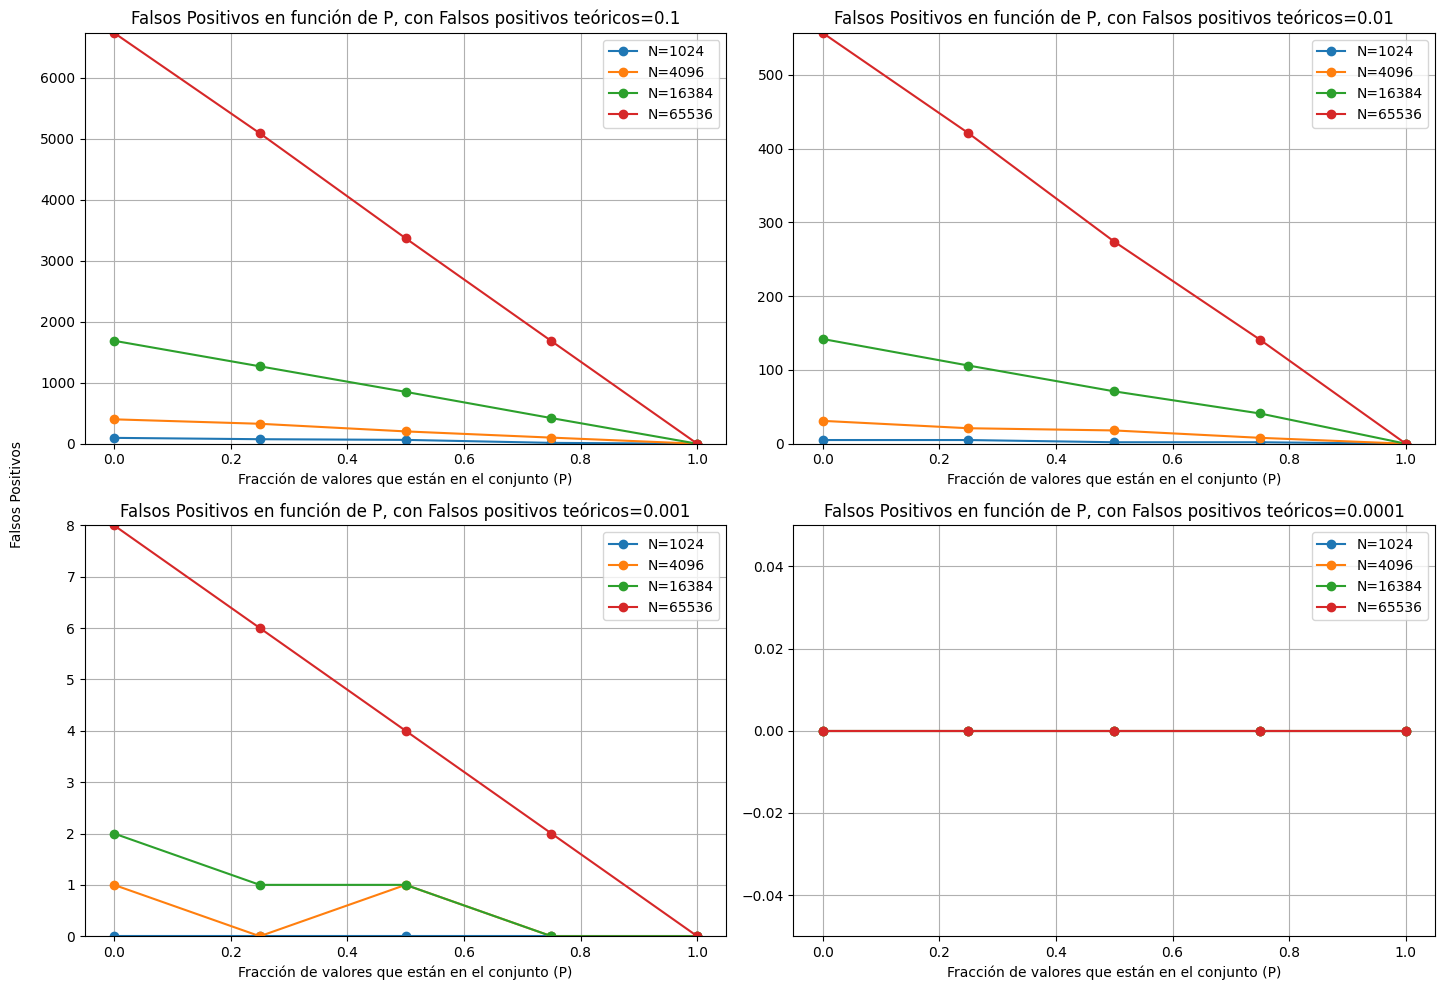

In [26]:
import matplotlib.pyplot as plt

# Obtener los valores únicos de desired_fp
unique_desired_fp = df['fp_rate_desired'].unique()

# Crear una figura y un conjunto de subplots en una cuadrícula de 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Iterar sobre cada valor único de desired_fp y su índice
for idx, desired_fp_value in enumerate(unique_desired_fp):
    # Filtrar el DataFrame
    filtered_df = df[df['fp_rate_desired'] == desired_fp_value]
    
    # Obtener los valores únicos de N
    unique_N = filtered_df['N'].unique()
    
    # Graficar para cada N en el subplot correspondiente
    for N in unique_N:
        subset = filtered_df[filtered_df['N'] == N]
        axes[idx].plot(subset['P'], subset['False Positives'], marker='o', label=f'N={N}')
    
    # Ajustar los límites del eje y para cada subplot
    axes[idx].set_ylim([filtered_df['False Positives'].min(), filtered_df['False Positives'].max()])
    
    # Añadir etiquetas y título a cada subplot
    axes[idx].set_xlabel('Fracción de valores que están en el conjunto (P)')
    axes[idx].set_title(f'Falsos Positivos en función de P, con Falsos positivos teóricos={desired_fp_value}')
    axes[idx].legend()
    axes[idx].grid(True)

# Añadir una etiqueta común para el eje y
fig.text(0.04, 0.5, 'Falsos Positivos', va='center', rotation='vertical')

# Ajustar el diseño
plt.tight_layout(rect=[0.05, 0, 1, 1])

# Mostrar el gráfico
plt.show()

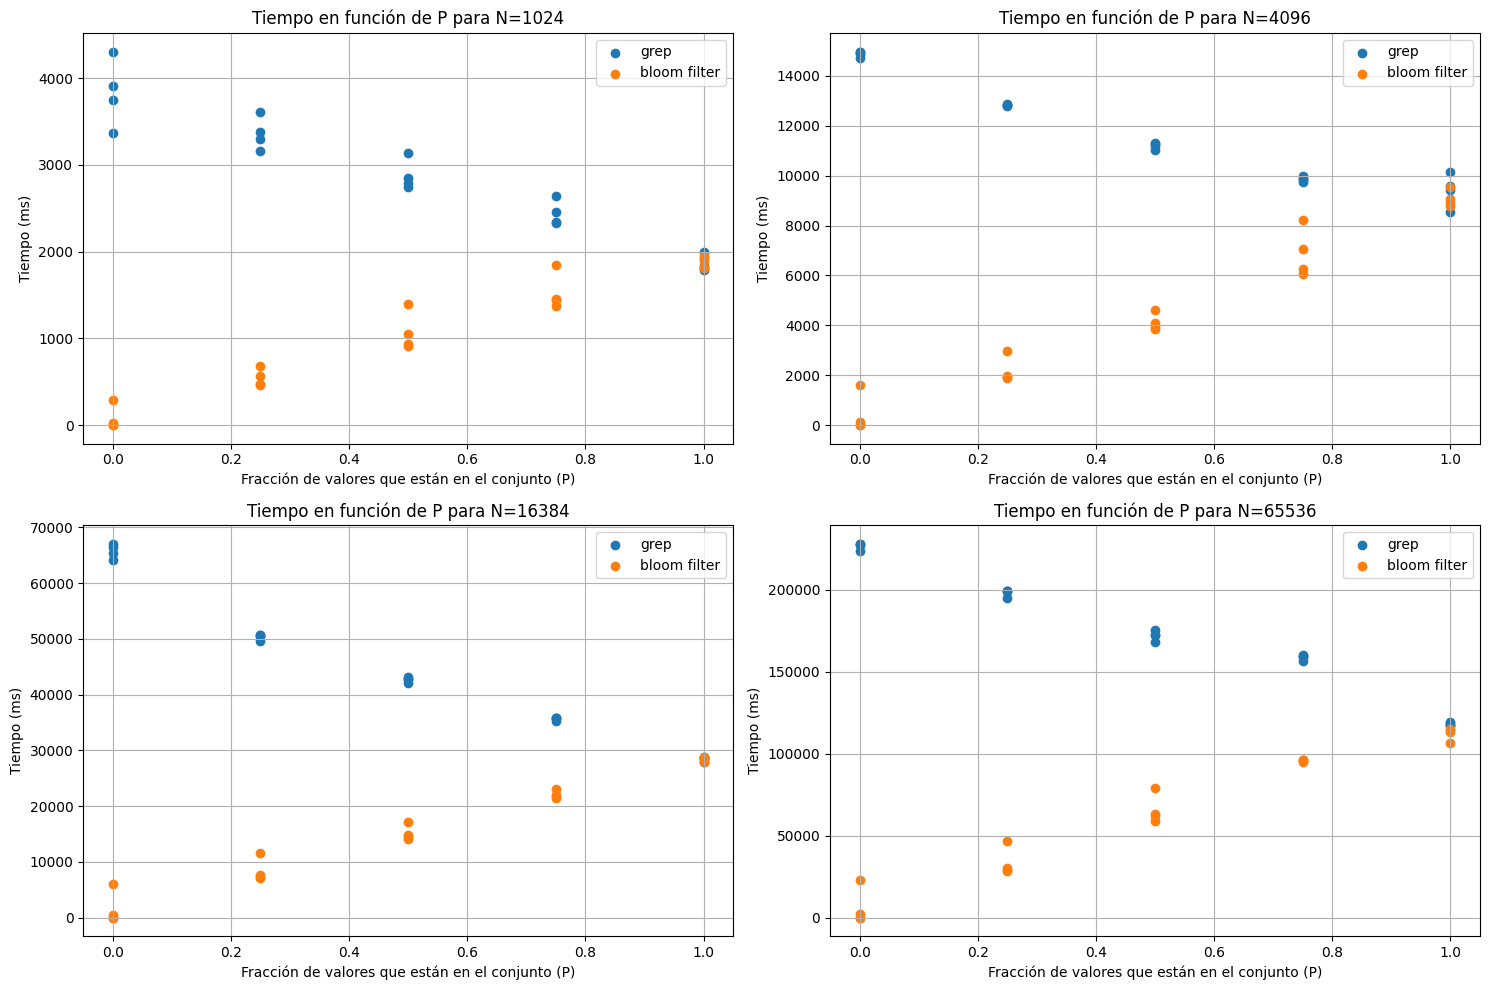

In [58]:
import matplotlib.pyplot as plt

# Obtener los valores únicos de N
unique_N = df['N'].unique()

# Crear una figura y un conjunto de subplots en una cuadrícula de 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Iterar sobre cada valor único de N y su índice
for idx, N_value in enumerate(unique_N):
    # Filtrar el DataFrame
    filtered_df = df[df['N'] == N_value]
    
    # Graficar el tiempo de grep en función de P
    axes[idx].scatter(filtered_df['P'], filtered_df['GREP Time (ms)'], marker='o', label='grep')
    
    # Graficar el tiempo de bloom filter en función de P
    axes[idx].scatter(filtered_df['P'], filtered_df['Bloom Filter Time (ms)'], marker='o', label='bloom filter')
    
    # Añadir etiquetas y título a cada subplot
    axes[idx].set_xlabel('Fracción de valores que están en el conjunto (P)')
    axes[idx].set_ylabel('Tiempo (ms)')
    axes[idx].set_title(f'Tiempo en función de P para N={N_value}')
    axes[idx].legend()
    axes[idx].grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

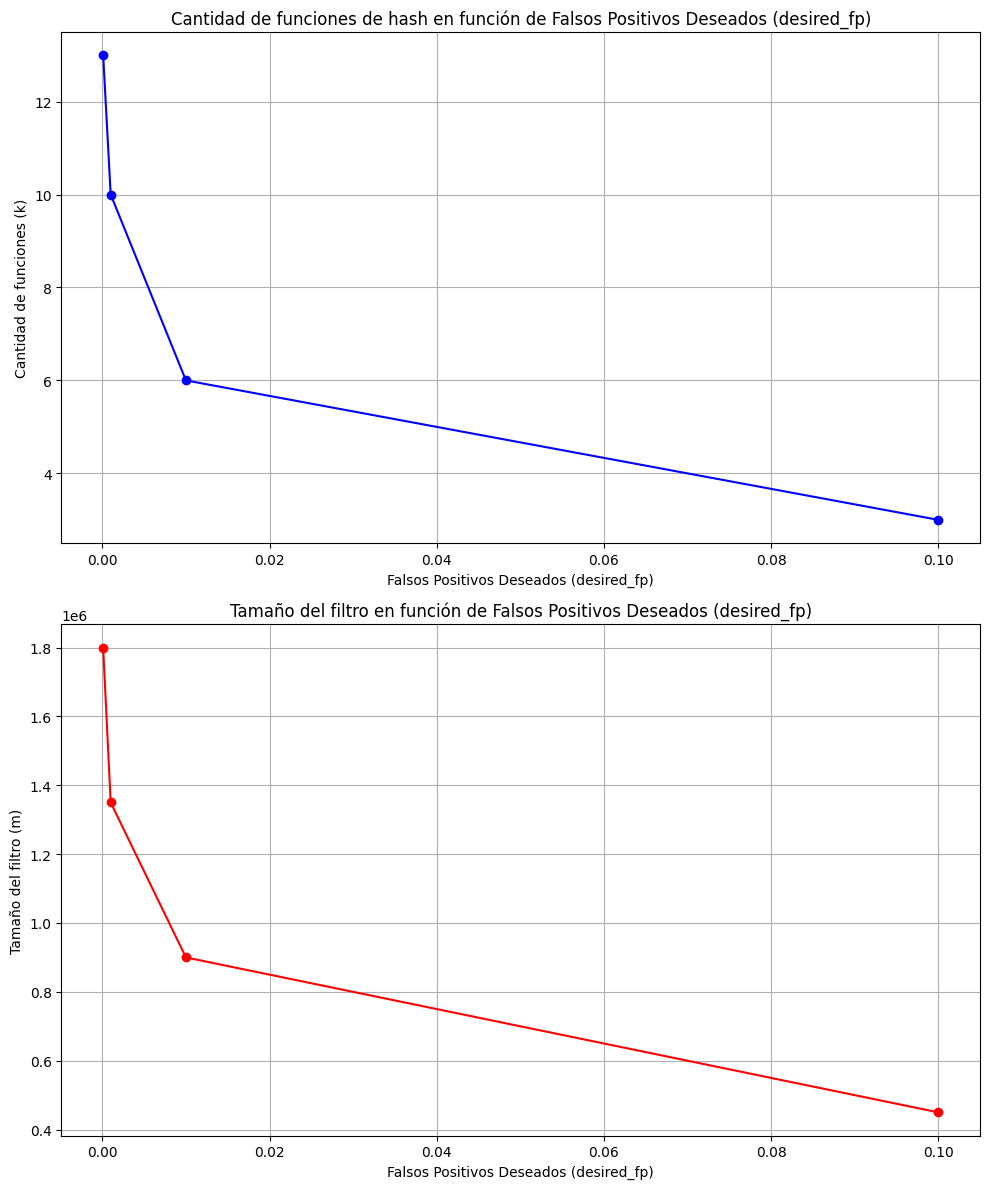

In [54]:
import matplotlib.pyplot as plt

# Obtener los valores únicos de desired_fp y los correspondientes valores de k y m
desired_fp_values = df['fp_rate_desired'].unique()
k_values = [df[df['fp_rate_desired'] == fp]['k'].iloc[0] for fp in desired_fp_values]
m_values = [df[df['fp_rate_desired'] == fp]['m'].iloc[0] for fp in desired_fp_values]

# Crear una figura y dos subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Graficar k en función de desired_fp en el primer subplot
ax1.plot(desired_fp_values, k_values, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Falsos Positivos Deseados (desired_fp)')
ax1.set_ylabel('Cantidad de funciones (k)')
ax1.set_title('Cantidad de funciones de hash en función de Falsos Positivos Deseados (desired_fp)')
ax1.grid(True)

# Graficar m en función de desired_fp en el segundo subplot
ax2.plot(desired_fp_values, m_values, marker='o', linestyle='-', color='r')
ax2.set_xlabel('Falsos Positivos Deseados (desired_fp)')
ax2.set_ylabel('Tamaño del filtro (m)')
ax2.set_title('Tamaño del filtro en función de Falsos Positivos Deseados (desired_fp)')
ax2.grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()
plt.show()

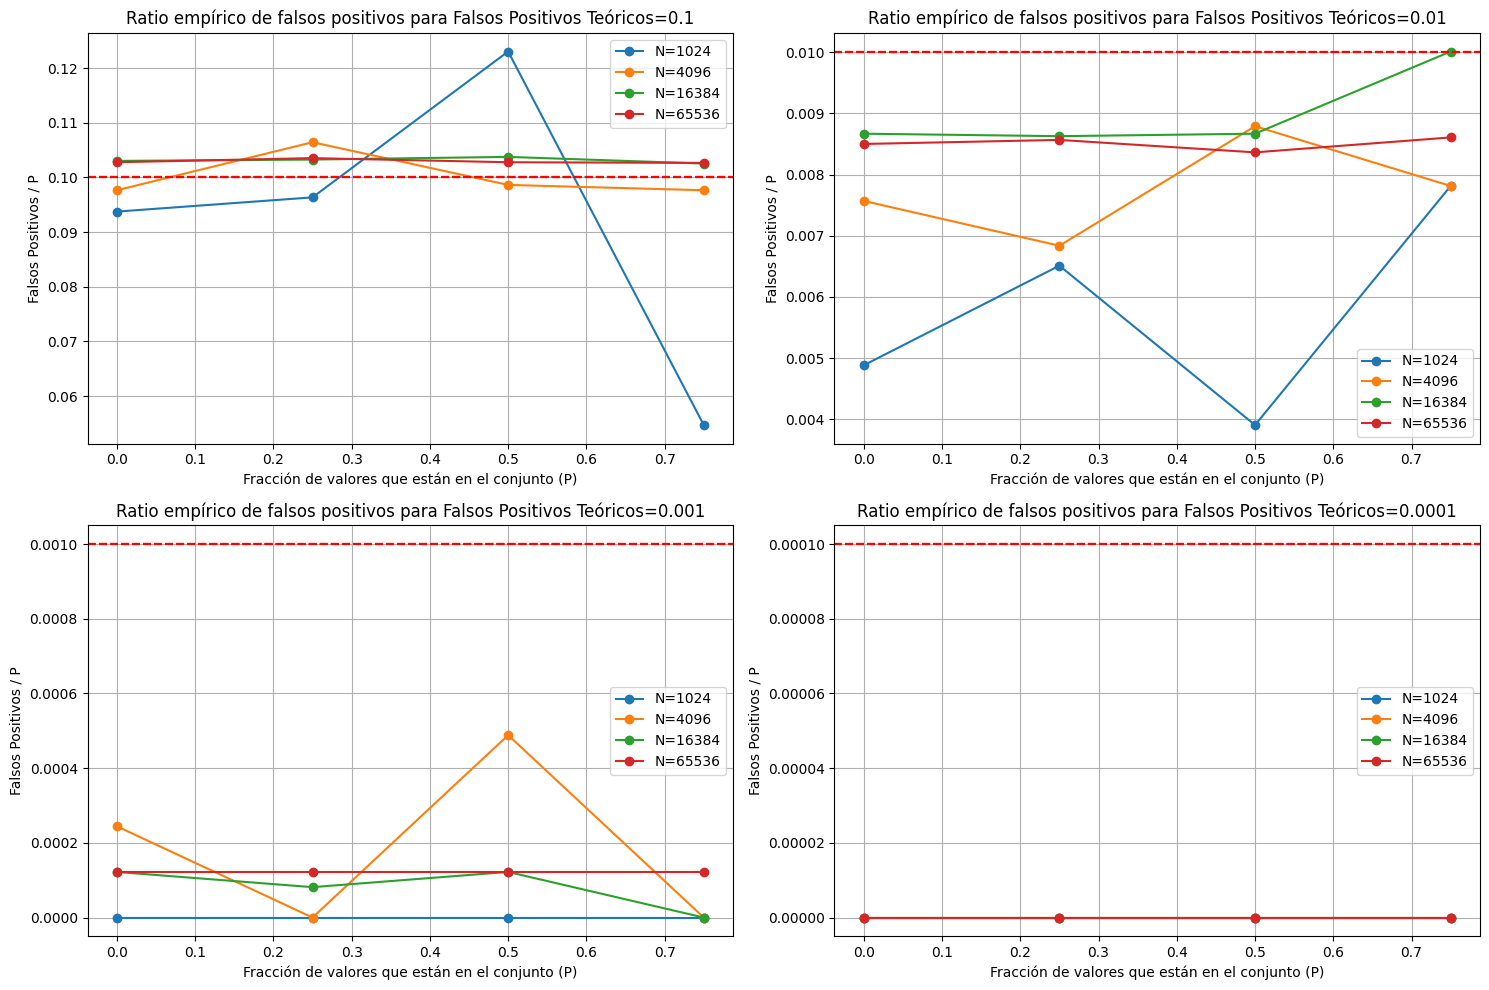

In [53]:
import matplotlib.pyplot as plt

# Obtener los valores únicos de desired_fp y N
unique_desired_fp = df['fp_rate_desired'].unique()
unique_N = df['N'].unique()

# Crear una figura y un conjunto de subplots en una cuadrícula de 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Iterar sobre cada valor único de desired_fp y su índice
for idx, desired_fp_value in enumerate(unique_desired_fp):
    # Filtrar el DataFrame por desired_fp
    filtered_df_fp = df[df['fp_rate_desired'] == desired_fp_value]
    
    # Iterar sobre cada valor único de N
    for N_value in unique_N:
        # Filtrar el DataFrame por N
        filtered_df_N = filtered_df_fp[filtered_df_fp['N'] == N_value]
        
        # Graficar el resultado de falsos_positivos / P en función de P
        axes[idx].plot(filtered_df_N['P'], filtered_df_N['empirical_fp_rate'], marker='o', label=f'N={N_value}')
        # Add a straight line representing the desired_fp value
        axes[idx].axhline(y=desired_fp_value, color='r', linestyle='--')


    
    # Añadir etiquetas y título a cada subplot
    axes[idx].set_xlabel('Fracción de valores que están en el conjunto (P)')
    axes[idx].set_ylabel('Falsos Positivos / P')
    axes[idx].set_title(f'Ratio empírico de falsos positivos para Falsos Positivos Teóricos={desired_fp_value}')
    axes[idx].legend()
    axes[idx].grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()